In [76]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
df = pd.read_csv('tweet.csv')

In [78]:
df.head()

,No,Date,Username,Tweet
0,1,2022-05-30 23:59:42+00:00,fednanen,@arkulari Makes me sick that some CFC fans hav...
1,2,2022-05-30 23:59:39+00:00,thvstwt,@Louis_Tomlinson did you watch the UCL final?
2,3,2022-05-30 23:59:22+00:00,lunatik1887,@MadeiraCakes @MoBob8208 @ethanpvt @Ultra_Suri...
3,4,2022-05-30 23:59:18+00:00,HxnchoIini,@mackutdd Says all of this but has only seen h...
4,5,2022-05-30 23:59:16+00:00,mxfahad3,"Vini, Havertz, Coman, Origi, Salah, Bale, Benz..."


**Clean Tweet From Unwanted String**

In [79]:
df.Tweet = df.Tweet.replace(r'\n',' ', regex=True) 

In [80]:
def preprocess(text):
    new_text = []
    for t in text.strip().split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [81]:
df['Tweet'] = df['Tweet'].map(lambda x: preprocess(x))

In [82]:
df.Tweet.head()

0    @user Makes me sick that some CFC fans have fo...
1                   @user did you watch the UCL final?
2    @user @user @user @user Stop talking about the...
3    @user Says all of this but has only seen his U...
4    Vini, Havertz, Coman, Origi, Salah, Bale, Benz...
Name: Tweet, dtype: object

**Load Model and Tokenizer**

In [83]:
roberta = f"cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
model.save_pretrained(roberta)
tokenizer.save_pretrained(roberta)
labels = ['Negative', 'Neutral', 'Positive']

**Sentiment Analysis**

In [84]:
def sentiment(tweet):
    encoded_tweet = tokenizer(preprocess(tweet), return_tensors='pt')
    output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    max_value = max(scores)
    list_scores = list(scores)
    index = list_scores.index(max_value)
    # print(labels[index], max_value)
    return pd.Series([max_value, labels[index]])

In [85]:
df[['Score', 'Label']] = df['Tweet'].apply(lambda x: sentiment(x))

In [86]:
df.head()

,No,Date,Username,Tweet,Score,Label
0,1,2022-05-30 23:59:42+00:00,fednanen,@user Makes me sick that some CFC fans have fo...,0.859798,Negative
1,2,2022-05-30 23:59:39+00:00,thvstwt,@user did you watch the UCL final?,0.880020,Neutral
2,3,2022-05-30 23:59:22+00:00,lunatik1887,@user @user @user @user Stop talking about the...,0.625723,Neutral
3,4,2022-05-30 23:59:18+00:00,HxnchoIini,@user Says all of this but has only seen his U...,0.506189,Neutral
4,5,2022-05-30 23:59:16+00:00,mxfahad3,"Vini, Havertz, Coman, Origi, Salah, Bale, Benz...",0.716288,Neutral


In [87]:
df.Tweet[98]

"This manhwa is awesome! I can't get enough of it!   #subwoolfer #UCL #comic #savetf2  http http"

In [88]:
df.to_csv('tweet_after_1.csv')

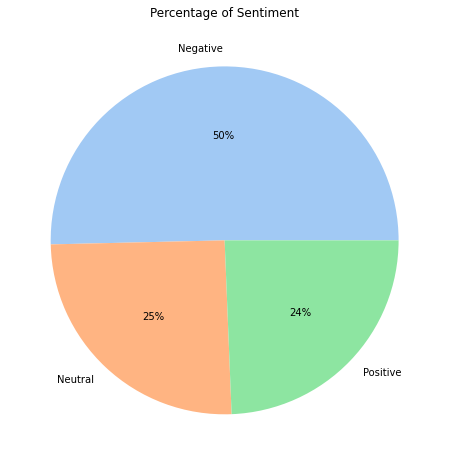

In [89]:
data = df['Label'].value_counts()
labels = df['Label'].unique()
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(8,8))
plt.title('Percentage of Sentiment')
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [90]:
df['Label'].value_counts()

Neutral     5037
Positive    2527
Negative    2436
Name: Label, dtype: int64